In [2]:
# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
import scipy.stats as stats
from scipy.stats import chi2_contingency, ttest_ind

# Librerías de visualización
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('../files/df_merged.csv', index_col=0)

### A/B Testing

¿Existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos?

In [4]:
#Filtramos el df por las dos columnas que nos interesa
df_education = df[['Education', 'Flights Booked']]

In [5]:
#Agrupamos por la columna 'Education' y calculamos las estadísticas descriptivas básicas para la columna 'Flights Booked'
stadistics = df.groupby('Education')['Flights Booked'].agg(['mean', 'std', 'min', 'max', 'count', 'sum'])

In [6]:
stadistics

,mean,std,min,max,count,sum
Education,,,,,,
Bachelor,4.129368,5.257359,0,39,251400,1038123
College,4.192209,5.287492,0,38,101712,426398
Doctor,4.202770,5.305066,0,32,17616,74036
High School or Below,4.208919,5.296142,0,31,18768,78993
Master,4.233432,5.266140,0,33,12192,51614


Hacemos dos grupos para realizar el A/B Testing:

Grupo de Control -> Grupo A (Educación Básica/Media):

- High School or Below
- College

Grupo de Prueba -> Grupo B (Educación Superior/Avanzada):

- Bachelor
- Master
- Doctor

Formulamos hipótesis:

- Hipótesis nula (H₀): No hay diferencia en las distribuciones de los dos grupos.
- Hipótesis alternativa (H₁): Hay una diferencia significativa en las distribuciones.

In [7]:
#Añadimos una columna a nuestro df filtrado que especifica a qué grupo pertenece cada valor de la columna 'Education'
df_education['Grupo'] = df_education['Education'].apply(lambda x: 'A' if x in ['High School or Below', 'College'] else 'B')

In [ ]:
#Comprobamos la columna 'Grupo'
df_education.head()

,Education,Flights Booked,Grupo
0,Bachelor,3,B
1,Bachelor,2,B
2,Bachelor,14,B
3,Bachelor,4,B
4,Bachelor,0,B


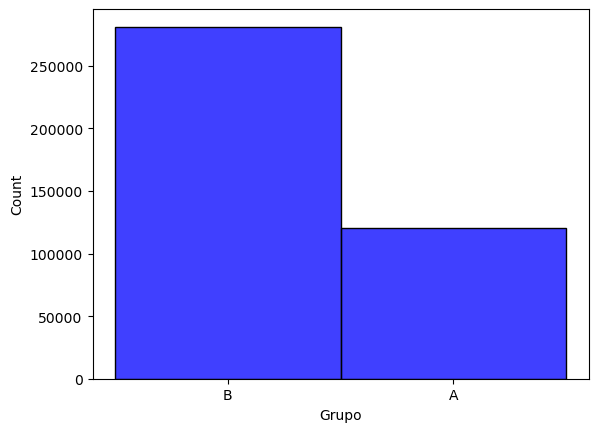

In [ ]:
#Vemos la distribución del df con un histplot

sns.histplot(x = "Grupo", data = df_education, color = "blue");

In [ ]:
#Probamos a hacer una tabla de contingencia
pd.crosstab(df_education['Grupo'], df_education['Flights Booked'], normalize=True) * 100

Flights Booked,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
Grupo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,14.484625,0.923602,1.036625,1.327647,0.931818,1.132222,1.021191,1.081187,1.062018,1.060774,0.998536,1.190974,0.782448,0.792655,0.53325,0.505616,0.337078,0.303718,0.227789,0.108791,0.097339,0.036845,0.003485,0.001743,0.001494,0.002241,0.001743,0.001992,0.000000,0.000747,0.000498,0.000747,0.000000,0.000498,0.000996,0.000000,0.000249,0.000000,0.000249,0.000000
B,34.104579,2.197726,2.317719,3.157426,2.229342,2.586834,2.400868,2.512896,2.484764,2.438958,2.309504,2.686911,1.790942,1.886290,1.22035,1.132969,0.753570,0.671666,0.511591,0.272351,0.199160,0.102069,0.006224,0.005228,0.004979,0.002987,0.003485,0.002987,0.002489,0.001494,0.000747,0.001494,0.001245,0.000249,0.001992,0.000747,0.000996,0.000249,0.000249,0.000249


Esta tabla de contingencia carece de sentido, por tanto, descartamos Chi Cuadrado como prueba de A/B.

Continuamos comprobando si los datos siguen una distribución normal o no:

In [11]:
def normalidad(dataframe, columna):
    """
    Evalúa la normalidad de una columna de datos de un DataFrame utilizando la prueba de Shapiro-Wilk.

    Parámetros:
        dataframe (DataFrame): El DataFrame que contiene los datos.
        columna (str): El nombre de la columna en el DataFrame que se va a evaluar para la normalidad.

    Returns:
        None: Imprime un mensaje indicando si los datos siguen o no una distribución normal.
    """

    statistic, p_value = stats.shapiro(dataframe[columna])
    if p_value > 0.05:
        print(f"Para la columna {columna} los datos siguen una distribución normal.")
    else:
        print(f"Para la columna {columna} los datos no siguen una distribución normal.")

In [12]:
metricas = ['Flights Booked']

for metrica in metricas:
    normalidad(df_education ,metrica)

Para la columna Flights Booked los datos no siguen una distribución normal.


Como los datos no siguen una distribución normal, realizamos el test Mann Whitney:

In [ ]:
def test_mann_whitney(dataframe, columnas_metricas, grupo_control, grupo_test, columna_grupos):

    """
    Realiza la prueba de Mann-Whitney U para comparar las medianas de las métricas entre dos grupos en un DataFrame dado.

    Parámetros:
    - dataframe (DataFrame): El DataFrame que contiene los datos.
    - columnas_metricas (list): Una lista de nombres de columnas que representan las métricas a comparar entre los grupos.
    - grupo_control (str): El nombre del grupo de control en la columna especificada por columna_grupos.
    - grupo_test (str): El nombre del grupo de test en la columna especificada por columna_grupos.
    - columna_grupos (str): El nombre de la columna que contiene la información de los grupos.

    Returns 
    No devuelve nada directamente, pero imprime en la consola si las medianas son diferentes o iguales para cada métrica.
    Se utiliza la prueba de Mann-Whitney U para evaluar si hay diferencias significativas entre los grupos.
    """
    # filtramos el DataFrame para quedarnos solo con los datos de control
    control = dataframe[dataframe[columna_grupos] == grupo_control]
    
    # filtramos el DataFrame para quedarnos solo con los datos de control
    test = dataframe[dataframe[columna_grupos] == grupo_test]
    
    
    # iteramos por las columnas de las metricas para ver si para cada una de ellas hay diferencias entre los grupos
    for metrica in columnas_metricas:
        
        # filtrams el conjunto de datos para quedarnos solo con la columna de la metrica que nos interesa
        metrica_control = control[metrica]
        metrica_test = test[metrica]
        
        # aplicamos el estadístico
        u_statistic, p_value = stats.mannwhitneyu(metrica_control, metrica_test)
        
        if p_value < 0.05:
            print(f"Para la métrica {metrica}, las medianas poseen una diferencia significativa.")
        else:
            print(f"Para la métrica {metrica}, las medianas no poseen una diferencia significativa.")
            
    



In [19]:
col = ['Flights Booked']

## llamamos a la función
test_mann_whitney(df_education, col, 'A', 'B', 'Grupo')

Para la métrica Flights Booked, las medianas poseen una diferencia significativa.


Por tanto, según el histplot realizado anteriormente, podemos afirmar que sí existe una diferencia significativa en el número de vuelos reservados entre los diferentes niveles educativos, siendo el Grupo B (Bachelor, Master y Doctor) el que más viajes realiza.